<a href="https://colab.research.google.com/github/3DLables/3DLabeler/blob/master/MouseSkullKPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mouse Skull Model
Import the relevant libraries and load drive.


In [0]:
import numpy as np
from tqdm import tqdm
import os
from google.colab import drive
drive.mount('/drive')
%cd /drive

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive


This is the github library that we are making on the backend. Loaded with pip. 
It's free so upload it.

In [0]:
pip install  https://github.com/3DLables/3DLabeler/archive/master.zip ## https://github.com/3DLables/3DLabeler/archive/package_refactor.zip

     / 1.8MB 5.7MB/s
  Created wheel for ThreeDLabeler: filename=ThreeDLabeler-0.1.2-cp36-none-any.whl size=5407 sha256=b0098516853a6ec2235701349a77db111188aade0498a1f56584d3272f4765e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-rg877o31/wheels/bf/17/fd/9bff15b364a3701f9ade6d41f38213bcefaf5dd3e2885a6d1c
Successfully built ThreeDLabeler


In [0]:
import ThreeDLabeler as td

In [0]:
basepath = '/drive/My Drive/Colab Notebooks/MouseSkulls/ReducedData/'
file_list = os.listdir(basepath)

In [0]:
skulls = []
points = []
for file in tqdm(file_list):
    file = np.load(basepath+file, allow_pickle=True)
    skulls.append(file[0])
    points.append(file[1])

100%|██████████| 218/218 [03:06<00:00,  1.46it/s]


In [0]:
skulls = np.array(skulls)

In [25]:
skulls.shape

(218, 128, 128, 128)

In [0]:
points = np.array(points)

In [0]:
points.shape

(218, 5, 3)

In [0]:
points[0]

array([[88.56115657, 52.51716346, 75.00089989],
       [70.20762833, 76.5855448 , 40.93514299],
       [51.88923916, 61.57721341,  1.75809896],
       [52.50764401, 82.42493911, 42.83472686],
       [29.59174929, 69.83438541, 78.80672787]])

In [0]:
img = td.Image(skulls[0], 1, points[0])

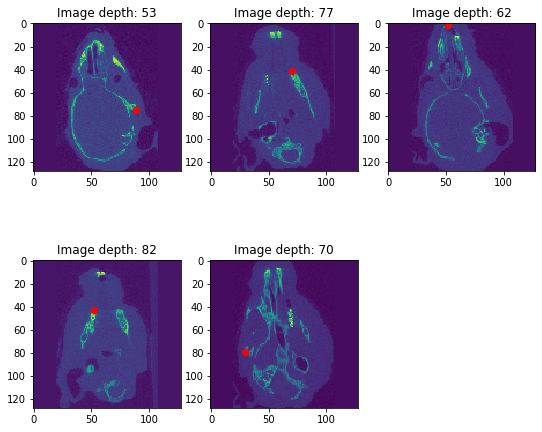

In [0]:
img.plot()

Unfortunetly these images are still too big for our algorimth.

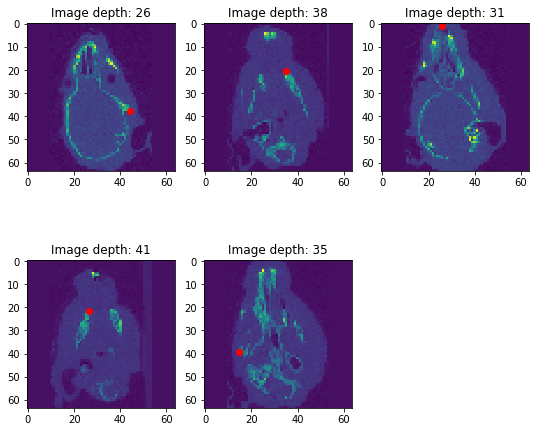

In [28]:
td.Image(skulls[0], 1, point_position=points[0]).scale(64).plot()

While this does not look as clear, it will fit a lot better in our training mode.

In [34]:
skulls64 = []
points64 = []

for i in tqdm(range(skulls.shape[0])):
    im = td.Image(skulls[i], 1, points[i])
    im = im.scale(64)
    skulls64.append(im.voxels)
    points64.append(im.point_position)
    

100%|██████████| 218/218 [00:43<00:00,  4.97it/s]


In [0]:
skulls64 = np.array(skulls64)
points64 = np.array(points64)

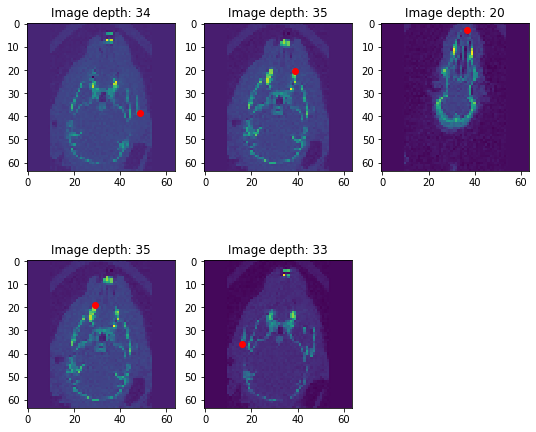

In [36]:
td.Image(skulls64[3], 1, points64[3]).plot()

In [0]:
skulls64 = skulls64.reshape(218, 64, 64, 64, 1)

In [0]:
points64 = points64.reshape(218, 15)

In [40]:
%tensorflow_version 2.x # in order to have tf and reduce warnings.

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # in order to have tf and reduce warnings.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv3D, Flatten, Dropout, Dense
from tensorflow.keras.layers import BatchNormalization, MaxPool3D, LeakyReLU


In [57]:
model = tf.keras.Sequential()

model.add(Conv3D(32, (3, 3, 3), padding='same', use_bias=False, 
                 input_shape=(64, 64, 64, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())


model.add(Conv3D(32, (3, 3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool3D())

model.add(Conv3D(64, (3, 3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool3D())

model.add(Flatten())
model.add(Dense(64, activation='relu', ))
model.add(Dropout(0.1))
model.add(Dense(15))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 64, 64, 64, 32)    864       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64, 32)    128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 64, 64, 32)    27648     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64, 32)    128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 32, 32, 32)   

In [0]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])

In [59]:
model.fit(skulls64, points64, epochs=10, batch_size=8)


Train on 218 samples
Epoch 1/10
218/218 [==============================] - 466s 2s/sample - loss: 2192.2689 - mae: 32.1986
Epoch 2/10
218/218 [==============================] - 459s 2s/sample - loss: 658.7803 - mae: 20.7540
Epoch 3/10
218/218 [==============================] - 457s 2s/sample - loss: 501.1170 - mae: 17.6091
Epoch 4/10
218/218 [==============================] - 462s 2s/sample - loss: 407.2800 - mae: 15.7312
Epoch 5/10
218/218 [==============================] - 457s 2s/sample - loss: 329.5373 - mae: 14.0642
Epoch 6/10
218/218 [==============================] - 458s 2s/sample - loss: 265.6377 - mae: 12.5468
Epoch 7/10
218/218 [==============================] - 459s 2s/sample - loss: 267.6383 - mae: 12.4056
Epoch 8/10
218/218 [==============================] - 458s 2s/sample - loss: 272.2548 - mae: 12.4589
Epoch 9/10
218/218 [==============================] - 466s 2s/sample - loss: 244.2214 - mae: 12.0862
Epoch 10/10
218/218 [==============================] - 458s 2s/sample

In [0]:
preds1 =model.predict(skulls64)

## Results
Here are he predictions.

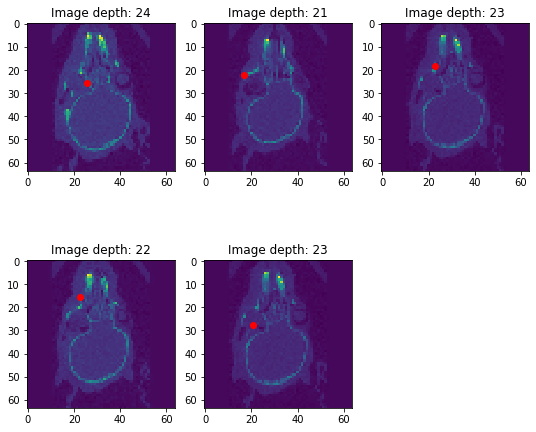

In [61]:
preds1 = preds1.reshape(218, 5, 3)

td.Image(skulls64.reshape(218, 64, 64, 64)[1], 1, point_position=preds1[1]).plot()

And the actuals:


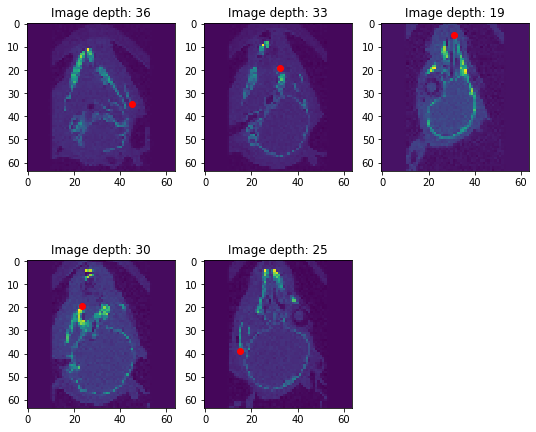

In [63]:
td.Image(skulls64.reshape(218, 64, 64, 64)[1], 1, point_position=points64.reshape(218, 5, 3)[1]).plot()